<a href="https://colab.research.google.com/github/youngseo21/esaa_22/blob/main/assignment_111822_classification(3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **08 분류 실습-캐글 산탄데르 고객 만족 예측**
____
- Kaggle의 산탄데르 고객 만족 데이터셋(Santander Customer Satisfaction) 데이터셋에 대해 고객 만족 여부를 XGBoost와 LightGBM을 활용해 예측해본다.
- Class Label 명은 TARGET이며, 이 값이 1이면 불만을 가진, 0이면 만족한 고객이다.
- 대부분의 고객이 만족이고, 불만족인 고객은 데이터의 일부이기 때문에(Label 값이 불균등하게 분포), 모델의 성능 평가는 ROC-AUC(ROC 곡선 영역)로 평가한다.


### | **데이터 전처리**
___
- XGBoost는 사이킷런 래퍼를 이용한다.
- 필요한 모듈을 로딩하고 학습 데이터를 DataFrame으로 로딩한다.

In [ ]:
# import package
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib

In [ ]:
# load data
cust_df = pd.read_csv("/content/drive/MyDrive/2022-1 ESAA/DataSet/santander-customer-satisfaction/train_satander.csv",encoding = 'latin-1')
print('dataset shape:', cust_df.shape)
cust_df.head(3)

dataset shape: (76020, 371)


ID  var3  var15  imp_ent_var16_ult1  imp_op_var39_comer_ult1  \
0   1     2     23                 0.0                      0.0   
1   3     2     34                 0.0                      0.0   
2   4     2     23                 0.0                      0.0   

   imp_op_var39_comer_ult3  imp_op_var40_comer_ult1  imp_op_var40_comer_ult3  \
0                      0.0                      0.0                      0.0   
1                      0.0                      0.0                      0.0   
2                      0.0                      0.0                      0.0   

   imp_op_var40_efect_ult1  imp_op_var40_efect_ult3  ...  \
0                      0.0                      0.0  ...   
1                      0.0                      0.0  ...   
2                      0.0                      0.0  ...   

   saldo_medio_var33_hace2  saldo_medio_var33_hace3  saldo_medio_var33_ult1  \
0                      0.0                      0.0                     0.0   
1                      0.0                      0.0                     0.0   
2                      0.0                      0.0                     0.0   

   saldo_medio_var33_ult3  saldo_medio_var44_hace2  saldo_medio_var44_hace3  \
0                     0.0                      0.0                      0.0   
1                     0.0                      0.0                      0.0   
2                     0.0                      0.0                      0.0   

   saldo_medio_var44_ult1  saldo_medio_var44_ult3     var38  TARGET  
0                     0.0                     0.0  39205.17       0  
1                     0.0                     0.0  49278.03       0  
2                     0.0                     0.0  67333.77       0  

[3 rows x 371 columns]

- 클래스 값 Column을 포함한 Feature가 371개 존재한다.
- Feature의 타입과 Null 값에 대해 좀 더 알아보자.

In [ ]:
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


- 111개의 Feature 형이고, 260개의 feature가 int형으로 모든 Feature가 숫자형이다.
- Null 값은 없다.
- 전체 데이터에서 만족/불만족의 비율을 알아보자.

In [ ]:
print(cust_df['TARGET'].value_counts())
unsatisfied_cnt = cust_df[cust_df['TARGET'] == 1].TARGET.count()
total_cnt = cust_df.TARGET.count()
print('unsatisfied 비율은 {0:.2f}'.format((unsatisfied_cnt / total_cnt)))

0    73012
1     3008
Name: TARGET, dtype: int64
unsatisfied 비율은 0.04


- 각 feature의 값 분포를 간단히 확인해보자.

In [ ]:
cust_df.describe()

ID           var3         var15  imp_ent_var16_ult1  \
count   76020.000000   76020.000000  76020.000000        76020.000000   
mean    75964.050723   -1523.199277     33.212865           86.208265   
std     43781.947379   39033.462364     12.956486         1614.757313   
min         1.000000 -999999.000000      5.000000            0.000000   
25%     38104.750000       2.000000     23.000000            0.000000   
50%     76043.000000       2.000000     28.000000            0.000000   
75%    113748.750000       2.000000     40.000000            0.000000   
max    151838.000000     238.000000    105.000000       210000.000000   

       imp_op_var39_comer_ult1  imp_op_var39_comer_ult3  \
count             76020.000000             76020.000000   
mean                 72.363067               119.529632   
std                 339.315831               546.266294   
min                   0.000000                 0.000000   
25%                   0.000000                 0.000000   
50%                   0.000000                 0.000000   
75%                   0.000000                 0.000000   
max               12888.030000             21024.810000   

       imp_op_var40_comer_ult1  imp_op_var40_comer_ult3  \
count             76020.000000             76020.000000   
mean                  3.559130                 6.472698   
std                  93.155749               153.737066   
min                   0.000000                 0.000000   
25%                   0.000000                 0.000000   
50%                   0.000000                 0.000000   
75%                   0.000000                 0.000000   
max                8237.820000             11073.570000   

       imp_op_var40_efect_ult1  imp_op_var40_efect_ult3  ...  \
count             76020.000000             76020.000000  ...   
mean                  0.412946                 0.567352  ...   
std                  30.604864                36.513513  ...   
min                   0.000000                 0.000000  ...   
25%                   0.000000                 0.000000  ...   
50%                   0.000000                 0.000000  ...   
75%                   0.000000                 0.000000  ...   
max                6600.000000              6600.000000  ...   

       saldo_medio_var33_hace2  saldo_medio_var33_hace3  \
count             76020.000000             76020.000000   
mean                  7.935824                 1.365146   
std                 455.887218               113.959637   
min                   0.000000                 0.000000   
25%                   0.000000                 0.000000   
50%                   0.000000                 0.000000   
75%                   0.000000                 0.000000   
max               50003.880000             20385.720000   

       saldo_medio_var33_ult1  saldo_medio_var33_ult3  \
count            76020.000000            76020.000000   
mean                12.215580                8.784074   
std                783.207399              538.439211   
min                  0.000000                0.000000   
25%                  0.000000                0.000000   
50%                  0.000000                0.000000   
75%                  0.000000                0.000000   
max             138831.630000            91778.730000   

       saldo_medio_var44_hace2  saldo_medio_var44_hace3  \
count             76020.000000             76020.000000   
mean                 31.505324                 1.858575   
std                2013.125393               147.786584   
min                   0.000000                 0.000000   
25%                   0.000000                 0.000000   
50%                   0.000000                 0.000000   
75%                   0.000000                 0.000000   
max              438329.220000             24650.010000   

       saldo_medio_var44_ult1  saldo_medio_var44_ult3         var38  \
count            76020.000000            76020.000000  7.602000e+04   

- `var3` Column의 경우 min 값이 -999999인데, NaN이나 특정 예외 값을 -999999로 변환했을 것이다. 
```python
print(cust_df.var3.values_conts()[:10])
```
- 위 코드로 `var3` 값을 조사해보면, -999999 값이 116개 있는 것을 알 수 있다. 그런데 -999999는 다른 값에 비해 편차가 너무 심하므로, 이를 가장 값이 많은 2로 변환한다.
- ID는 단순 식별자에 불과하므로 Feature를 드롭한다.
- Class 데이터셋과 Feature 데이터셋은 분리해 별도의 데이터셋으로 저장한다.

In [ ]:
# var3 Feature 값 대체 및 ID Feature 드롭
cust_df['var3'].replace(-999999, 2, inplace = True)
cust_df.drop('ID', axis = 1, inplace=True)

In [ ]:
# Feature/Label 데이터셋 분리
# Label Column은 DataFrame의 맨 마지막에 위치 : Column 위치 -1로 분리
X_features = cust_df.iloc[:, :-1]
y_labels = cust_df.iloc[:, -1]
print('Feature 데이터 shape:{0}'.format(X_features.shape))

Feature 데이터 shape:(76020, 369)


- 학습과 성능 평가를 위해 원본 데이터셋을 학습/테스트 데이터셋으로 분리한다.
- 비대칭한 데이터셋이므로 학습 데이터셋과 테스트 데이터셋에서 Target 값의 분포가 비슷한지 확인한다.

In [ ]:
# 학습/테스트 데이터셋으로 분리
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels, test_size = 0.2, random_state = 0)

In [ ]:
train_cnt = y_train.count()
test_cnt = y_test.count()
print('학습 세트 Shape:{0}, 테스트 세트 Shape:{1}'.format(X_train.shape , X_test.shape))

학습 세트 Shape:(60816, 369), 테스트 세트 Shape:(15204, 369)


In [ ]:
print(' 학습 세트 Label 값 분포 비율')
print(y_train.value_counts()/train_cnt)
print('\n 테스트 세트 Label 값 분포 비율')
print(y_test.value_counts()/test_cnt)

 학습 세트 Label 값 분포 비율
0    0.960964
1    0.039036
Name: TARGET, dtype: float64

 테스트 세트 Label 값 분포 비율
0    0.9583
1    0.0417
Name: TARGET, dtype: float64


- 학습, 테스트 데이터셋 모두 원본 데이터와 TARGET 값 분포가 유사하다.

### | **XGBoost 모델 학습과 하이퍼 파라미터 튜닝**
___
- XGBoost의 학습 모델을 생성하고 예측 결과를 ROC AUC로 평가한다.
- 사이킷런 래퍼인 `XGBClassifier`을 기반으로 학습한다.
- `n_estimators`는 500, `early_stopping_rounds`는 100으로 설정한다.
- 성능 평가 기준이 ROC-AUC이므로, `eval_metric`은 `auc`로한다.
- 평가 데이터셋은 앞에서 분리한 테스트 데이터셋이다. 
  + 
```python
eval_set = [(X_train, y_train), (X_test, y_test)]
```
  + 다만 이는 과적합될 가능성을 증가시키므로 유의해야 한다. 

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

# n_estimators는 500, random state는 예제 수행 시마다 동일 예측 결과를 위해 설정
xgb_clf = XGBClassifier(n_estimators=500, random_state=156)

# 성능 평가 지표를 auc로, 조기 중단 파라미터는 100으로 설정하고 학습
xgb_clf.fit(X_train, y_train, early_stopping_rounds = 100, eval_metric="auc", eval_set = [(X_train, y_train), (X_test, y_test)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1],average = 'macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.799928	validation_1-auc:0.803548
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.802222	validation_1-auc:0.805222
[2]	validation_0-auc:0.80819	validation_1-auc:0.813162
[3]	validation_0-auc:0.8127	validation_1-auc:0.813243
[4]	validation_0-auc:0.81648	validation_1-auc:0.816979
[5]	validation_0-auc:0.816018	validation_1-auc:0.816629
[6]	validation_0-auc:0.816474	validation_1-auc:0.817776
[7]	validation_0-auc:0.818148	validation_1-auc:0.818464
[8]	validation_0-auc:0.81806	validation_1-auc:0.818295
[9]	validation_0-auc:0.817039	validation_1-auc:0.818087
[10]	validation_0-auc:0.818318	validation_1-auc:0.818749
[11]	validation_0-auc:0.818711	validation_1-auc:0.818521
[12]	validation_0-auc:0.818673	validation_1-auc:0.818516
[13]	validation_0-auc:0.819156	validation_1-auc:0.818998
[14]	validation_0-auc:0.819847	validation_1-auc:0.81999
[15

- 테스트 데이터셋으로 예측했을 때, ROC AUC는 약 0.8419이다.
- 다음에는 XGBoost의 하이퍼 파라미터를 튜닝해보자.
- Column의 개수가 많으므로 과적합을 가정하고, `max_depth`, `min_child_weight`, `colsample_bytree` 하이퍼 파라미터만 일차적으로 튜닝한다.
- 학습 시간이 많이 필요한 ML 모델인 경우, 하이퍼 파라미터를 튜닝을 수행할 때,
  1. 먼저 2~3개 정도의 파라미터를 결합해 최적 파라미터를 찾는다.
  2.  이를 기반으로 다시 1~2개 파라미터를 결합해 파라미터 튜닝을 수행한다.
- 다음 예제에서는 수행 시간이 오래 걸리므로 `n_estimators`는 300으로 줄이고, `early_stopping_rounds`를 30으로 줄여 테스트 한 뒤, 나중에 하이퍼 파라미터 튜닝이 완료되면 다시 증가시킨다.

In [ ]:
from sklearn.model_selection import GridSearchCV

# 하이퍼 파라미터 테스트의 수행 속도를 향상시키기 위해 n_estimators를 100으로 감소
xgb_clf = XGBClassifier(n_estimators=100)

params = {'max_depth':[5, 7], 
          'min_child_weight':[1,3],
          'colsample_bytree':[0.5, 0.75]}

# cv는 3으로 지정 
gridcv = GridSearchCV(xgb_clf, param_grid=params, cv = 3)
gridcv.fit(X_train, y_train, early_stopping_rounds=30, eval_metric="auc", eval_set=[(X_train, y_train), (X_test, y_test)])

print('GridSearchCV 최적 파라미터:', gridcv.best_params_) 

xgb_roc_score = roc_auc_score(y_test, gridcv.predict_proba(X_test)[:,1], average = 'macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.715421	validation_1-auc:0.722463
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.802772	validation_1-auc:0.807648
[2]	validation_0-auc:0.800147	validation_1-auc:0.804566
[3]	validation_0-auc:0.805692	validation_1-auc:0.809325
[4]	validation_0-auc:0.814807	validation_1-auc:0.816951
[5]	validation_0-auc:0.810346	validation_1-auc:0.812634
[6]	validation_0-auc:0.810623	validation_1-auc:0.814491
[7]	validation_0-auc:0.818556	validation_1-auc:0.820561
[8]	validation_0-auc:0.822006	validation_1-auc:0.823553
[9]	validation_0-auc:0.820433	validation_1-auc:0.821292
[10]	validation_0-auc:0.826212	validation_1-auc:0.825279
[11]	validation_0-auc:0.830077	validation_1-auc:0.827817
[12]	validation_0-auc:0.832328	validation_1-auc:0.828775
[13]	validation_0-auc:0.832008	validation_1-auc:0.827865
[14]	validation_0-auc:0.830319	validation_1-auc:0.82674

- `colsample_bytree`는 0.5, `max_depth`는 5, 그리고 `min_child_weight`는 1일때, ROC AUC 값이 0.8461로 조금 개선되었다.
- GridSearchCV로 구한 최적 하이퍼 파라미터로 설정한 후, 
```python
n_estimators = 1000
learning_rate = 0.02
reg_alpha = 0.03
```
으로 설정하여, 다시 `XGBClassifier`를 학습시킨다.

In [ ]:
# n_estimators는 1000, learning_rate = 0.02, reg_alpha = 0.03
xgb_clf = XGBClassifier(n_estimators = 1000, random_state = 156, learning_rate = 0.02, max_depth = 5, min_child_weight = 1, colsample_bytree = 0.5, reg_alpha = 0.03)

# evaluation metric을 auc로, early stopping은 200 으로 설정하고 학습 수행. 
xgb_clf.fit(X_train, y_train, early_stopping_rounds = 200, eval_metric = "auc", eval_set=[(X_train, y_train), (X_test, y_test)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1],average = 'macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.817665	validation_1-auc:0.814986
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 200 rounds.
[1]	validation_0-auc:0.81987	validation_1-auc:0.814699
[2]	validation_0-auc:0.818798	validation_1-auc:0.813863
[3]	validation_0-auc:0.821696	validation_1-auc:0.815841
[4]	validation_0-auc:0.827716	validation_1-auc:0.822558
[5]	validation_0-auc:0.822253	validation_1-auc:0.818887
[6]	validation_0-auc:0.825218	validation_1-auc:0.818733
[7]	validation_0-auc:0.826898	validation_1-auc:0.820357
[8]	validation_0-auc:0.832836	validation_1-auc:0.827253
[9]	validation_0-auc:0.833574	validation_1-auc:0.827534
[10]	validation_0-auc:0.832205	validation_1-auc:0.825896
[11]	validation_0-auc:0.829664	validation_1-auc:0.824912
[12]	validation_0-auc:0.828593	validation_1-auc:0.824409
[13]	validation_0-auc:0.829674	validation_1-auc:0.824657
[14]	validation_0-auc:0.833554	validation_1-auc:0.82782

- ROC AUC 값이 약 0.8456으로 이전보다 살짝 향상된 결과를 보였다.
- 한 가지 아쉬운 점은 XGBoost가 GBM보다 빠르지만 그래도 수행 시간이 상당히 많이 요구된다는 것이다.
- 튜닝된 모델에서 각 Feature의 중요도를 그래프로 나타내보자. xgboost 모듈의 `plot_importance()` 메서드를 사용할 것이다.

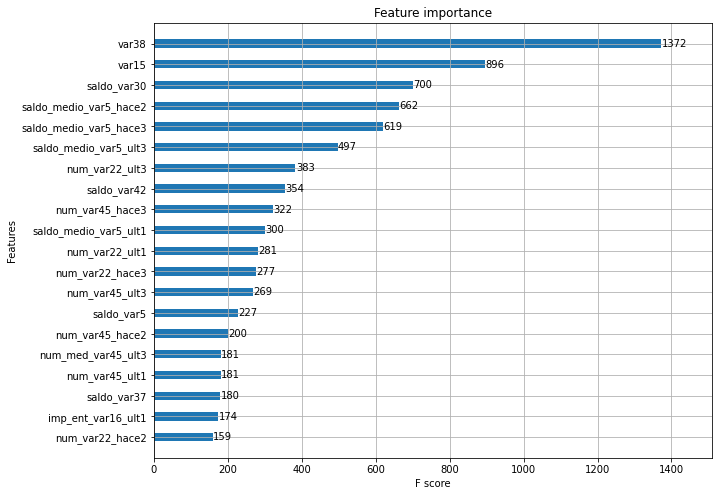

In [ ]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1,1,figsize = (10,8))
plot_importance(xgb_clf, ax = ax , max_num_features = 20, height = 0.4)

### | **LightGBM 모델 학습과 하이퍼 파라미터 튜닝**
___
- 앞에서 만들어진 데이터셋을 기반으로 LightGBm으로 학습한 후, ROC AUC를 측정해보자.
- 
```python
n_estimators = 500
early_stopping_rounds = 100
```
그리고 평가 데이터셋은 테스트 데이터셋, `eval_metric`은 `auc`로 설정한다.

In [ ]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=500)

evals = [(X_test, y_test)]
lgbm_clf.fit(X_train, y_train, early_stopping_rounds = 100, eval_metric = "auc", eval_set = evals, verbose = True)

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:,1],average='macro')
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

[1]	valid_0's auc: 0.817384	valid_0's binary_logloss: 0.165046
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.81863	valid_0's binary_logloss: 0.16
[3]	valid_0's auc: 0.827411	valid_0's binary_logloss: 0.156287
[4]	valid_0's auc: 0.832175	valid_0's binary_logloss: 0.153416
[5]	valid_0's auc: 0.83481	valid_0's binary_logloss: 0.151206
[6]	valid_0's auc: 0.834721	valid_0's binary_logloss: 0.149303
[7]	valid_0's auc: 0.83659	valid_0's binary_logloss: 0.147804
[8]	valid_0's auc: 0.837602	valid_0's binary_logloss: 0.146466
[9]	valid_0's auc: 0.838114	valid_0's binary_logloss: 0.145476
[10]	valid_0's auc: 0.838472	valid_0's binary_logloss: 0.144681
[11]	valid_0's auc: 0.83808	valid_0's binary_logloss: 0.143978
[12]	valid_0's auc: 0.837771	valid_0's binary_logloss: 0.14341
[13]	valid_0's auc: 0.838063	valid_0's binary_logloss: 0.142835
[14]	valid_0's auc: 0.838485	valid_0's binary_logloss: 0.142296
[15]	valid_0's auc: 0.838542	valid_0's binary_logloss: 0.14

- LightGBM 수행 결과 ROC AUC는 약 0.8396이다.
- LightGBM을 직접 수행해보면, XGBoost보다 학습에 걸리는 시간이 좀 더 단축됐음을 느낄 수 있다.
- GridSearchCV로 좀 더 다양한 하이퍼 파라미터를 튜닝해보자. 튜닝할 하이퍼파라미터는 `num_leaves`, `max_depth`, `min_child_samples`, `subsample`이다.

In [ ]:
from sklearn.model_selection import GridSearchCV

# 하이퍼 파라미터 테스트의 수행 속도를 향상시키기 위해 n_estimators를 100으로 감소
lgbm_clf = LGBMClassifier(n_estimators = 200)

params = {'num_leaves': [32, 64 ],
          'max_depth':[128, 160],
          'min_child_samples':[60, 100],
          'subsample':[0.8, 1]}


# cv는 3으로 지정 
gridcv = GridSearchCV(lgbm_clf, param_grid=params, cv = 3)
gridcv.fit(X_train, y_train, early_stopping_rounds = 30, eval_metric = "auc", eval_set = [(X_train, y_train), (X_test, y_test)])

print('GridSearchCV 최적 파라미터:', gridcv.best_params_)
lgbm_roc_score = roc_auc_score(y_test, gridcv.predict_proba(X_test)[:,1], average = 'macro')
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

[1]	valid_0's auc: 0.820235	valid_0's binary_logloss: 0.156085	valid_1's auc: 0.81613	valid_1's binary_logloss: 0.164992
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's auc: 0.825778	valid_0's binary_logloss: 0.150951	valid_1's auc: 0.821835	valid_1's binary_logloss: 0.159874
[3]	valid_0's auc: 0.832192	valid_0's binary_logloss: 0.147167	valid_1's auc: 0.827305	valid_1's binary_logloss: 0.156391
[4]	valid_0's auc: 0.837507	valid_0's binary_logloss: 0.144132	valid_1's auc: 0.8334	valid_1's binary_logloss: 0.15332
[5]	valid_0's auc: 0.842275	valid_0's binary_logloss: 0.141652	valid_1's auc: 0.836036	valid_1's binary_logloss: 0.150954
[6]	valid_0's auc: 0.844971	valid_0's binary_logloss: 0.139662	valid_1's auc: 0.838026	valid_1's binary_logloss: 0.149041
[7]	valid_0's auc: 0.846612	valid_0's binary_logloss: 0.138002	valid_1's auc: 0.837776	valid_1's binary_logloss: 0.147504
[8]	valid_0's auc: 0.848539	valid_0's binary_logloss: 0.136579	valid_1's auc: 0.839506	v

- 해당 하이퍼 파라미터를 LightGBM에 적용하고 다시 학습해 ROC AUC 측정 결과를 출력해보자.

In [ ]:
lgbm_clf = LGBMClassifier(n_estimators = 1000, num_leaves = 32, subsample = 0.8, min_child_samples = 100, max_depth = 128)

evals = [(X_test, y_test)]
lgbm_clf.fit(X_train, y_train, early_stopping_rounds = 100, eval_metric = "auc", eval_set = evals, verbose = True)

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:,1],average = 'macro')
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

[1]	valid_0's auc: 0.819488	valid_0's binary_logloss: 0.165016
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.822387	valid_0's binary_logloss: 0.159711
[3]	valid_0's auc: 0.829542	valid_0's binary_logloss: 0.156068
[4]	valid_0's auc: 0.834917	valid_0's binary_logloss: 0.153141
[5]	valid_0's auc: 0.837871	valid_0's binary_logloss: 0.150804
[6]	valid_0's auc: 0.839548	valid_0's binary_logloss: 0.148876
[7]	valid_0's auc: 0.841812	valid_0's binary_logloss: 0.147225
[8]	valid_0's auc: 0.842382	valid_0's binary_logloss: 0.14594
[9]	valid_0's auc: 0.842811	valid_0's binary_logloss: 0.144866
[10]	valid_0's auc: 0.843186	valid_0's binary_logloss: 0.143872
[11]	valid_0's auc: 0.843465	valid_0's binary_logloss: 0.14305
[12]	valid_0's auc: 0.843222	valid_0's binary_logloss: 0.142376
[13]	valid_0's auc: 0.843564	valid_0's binary_logloss: 0.141783
[14]	valid_0's auc: 0.843389	valid_0's binary_logloss: 0.141419
[15]	valid_0's auc: 0.84365	valid_0's binary_logloss

## **09 분류 실습-캐글 신용카드 사기 검출**
____
- Kaggle의 신용카드 데이터셋을 이용해 신용카드 사기 검출 분류 실습을 해보자.
- 해당 데이터셋의 Label인 Class는 매우 불균형한 분포를 가지고 있다. Class는 사기가 아닌 정상적인 신용카드 트랜잭션은 0, 신용카드 사기 트랜잭션은 1로 분류한다.
- 일반적으로 사기와 같은 이상 현상은 전체 데이터에서 차지하는 비중이 적을 수밖에 없기 때문에, 사기 검출(Fraud Detection)이나 이상 검출(Anomaly Detection)과 같은 데이터셋은 Label 값이 매우 불균형한 분포를 가지기 쉽다.

### | **언더 샘플링과 오버 샘플링의 이해**
___
- Label이 불균형 분포를 가진 데이터셋을 학습시키면, 이상 레이블을 가지는 데이터 건수가 정상 레이블을 가진 데이터 건수에 비해 너무 적어, 제대로 다양한 유형을 학습하지 못해, 예측 성능에 문제가 발생할 수 있다.
- 즉, 정상 레이블로 치우쳐 학습을 해, 이상 데이터 검출이 어려워진다.
- 불균형한 레이블 값 분포로 인한 문제점을 해결하기 위해서는 적절한 학습 데이터를 확보하는 방안이 필요하다.
  1. **오버 샘플링(Oversampling)** : 적은 레이블을 가진 데이터셋을 많은 레이블을 가진 데이터셋 수준으로 증식. 동일한 데이터를 단순히 증식하면 과적합이 되기 때문에, 원본 데이터의 Feature 값들을 약간씩만 변경하여 증식한다. 대표적으로 SMOTE 방법이 있따.
  2. **언더 샘플링(Undersampling)** : 많은 레이블을 가진 데이터셋을 적은 레이블을 가진 데이터셋 수준으로 감소. 과도하게 정상 레이블로 학습/예측하는 부작용은 개성하지만 너무 많은 정상 레이블 데이터를 감소시켜, 오히려 정상 레이블로 제대로 된 학습을 수행할 수 없어 잘 적용하지 않는다.

In [ ]:
!pip install imbalanced-learn

### | **데이터 일차 가공 및 모델 학습/예측/평가**
___

In [ ]:
# import package
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [ ]:
# load data
card_df = pd.read_csv('/content/drive/MyDrive/2022-1 ESAA/DataSet/creditcard.csv')
card_df.head(3)

Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   

        V26       V27       V28  Amount  Class  
0 -0.189115  0.133558 -0.021053  149.62      0  
1  0.125895 -0.008983  0.014724    2.69      0  
2 -0.139097 -0.055353 -0.059752  378.66      0  

[3 rows x 31 columns]

- V로 시작하는 Feature들의 의미를 알 수 없다.
- `Time`의 겨우, 데이터 생성과 관련된 작업용 속성으로 큰 의미가 없으므로 제거한다.
- `Amount`는 신용카드 트랙잭션 금액을 의미한다.
- `Class`는 Label로 0의 경우, 정상, 1의 경우, 사기 트랙잭션이다.

In [ ]:
card_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

- 전체 284,807개의 레코드에서 결측치(Missing Value)는 없으며, Class 레이블만 int 형이고, 나머지 Feature들은 모두 float형이다.
- `get_preprocessed_df()` 함수 : 인자로 입력된 DataFrame을 복사한 뒤, 이를 가공하여 반환하는 함수. 우선 `Time` Feature만 삭제한다.
- `get_train_test()` 함수 : 데이터 가공 후 학습/테스트 데이터셋을 반환하는 함수

In [ ]:
from sklearn.model_selection import train_test_split

# 인자로 입력받은 DataFrame을 복사한 뒤, Time만 삭제하고 복사된 DataFrame 반환
def get_preprocessed_df(df = None):
    df_copy = df.copy()
    df_copy.drop('Time', axis = 1, inplace = True)
    return df_copy

In [ ]:
# 사전 데이터 가공 후 학습과 테스트 데이터 세트를 반환하는 함수
def get_train_test_dataset(df=None):
    # 인자로 입력된 DataFrame의 사전 데이터 가공이 완료된 복사 DataFrame 반환
    df_copy = get_preprocessed_df(df)

    # DataFrame의 맨 마지막 Column이 레이블, 나머지는 Feature들
    X_features = df_copy.iloc[:, :-1]
    y_target = df_copy.iloc[:, -1]

    # train_test_split( )으로 학습과 테스트 데이터 분할. stratify=y_target으로 Stratified 기반 분할
    X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size = 0.3, random_state = 0, stratify = y_target)

    # 학습과 테스트 데이터 세트 반환
    return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

- 생성된 학습 데이터셋과 테스트 데이터셋의 Label 값 비율을 백분율로 환산하여 서로 비슷하게 분활되었는지 확인한다.

In [ ]:
print('학습 데이터 레이블 값 비율')
print(y_train.value_counts()/y_train.shape[0] * 100)

print('테스트 데이터 레이블 값 비율')
print(y_test.value_counts()/y_test.shape[0] * 100)

학습 데이터 레이블 값 비율
0    99.827451
1     0.172549
Name: Class, dtype: float64
테스트 데이터 레이블 값 비율
0    99.826785
1     0.173215
Name: Class, dtype: float64


- 학습 데이터의 Label 값 비율은 0.172%, 테스트 데이터의 Label 값 비율은 0.173%로 큰 차이 없이 분할되었따.
- 이제 로지스틱 회귀와 LightGBM 기반의 모델이 데이터 가공을 수행하면서 예측 성능이 어떻게 변하는지 살펴보자.

In [ ]:
# 3장의 예측 성능 평가 함수
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [ ]:
# 로지스틱 회귀
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:, 1]

# 3장에서 사용한 get_clf_eval() 함수를 이용하여 평가 수행. 
get_clf_eval(y_test, lr_pred, lr_pred_proba)

오차 행렬
[[85281    14]
 [   56    92]]
정확도: 0.9992, 정밀도: 0.8679, 재현율: 0.6216, F1: 0.7244, AUC:0.9609


- 테스트 데이터셋으로 측정 시 재현율(Recall)이 0.6081, ROC AUC는 0.9709이다.
- 이번에는 LightGBM을 이용한 모델을 만들어보자.
- 뒤에서 반복적으로 모델을 변경해 학습/예측/평가할 것이므로, 이를 위한 별도의 함수를 생성한다.
- `get_model_train_eval()` 함수 : 인자로 사이킷런의 Estimator 객체와 학습/테스트 데이터셋을 받아, 학습/예측/평가를 수행한다.

In [ ]:
# 인자로 사이킷런의 Estimator객체와, 학습/테스트 데이터 세트를 입력 받아서 학습/예측/평가 수행
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:, 1]
    get_clf_eval(tgt_test, pred, pred_proba)

- 신용카드 데이터셋은 매우 불균형하게 레이블 값이 분포하므로, `LGBMClassifier` 객체를 생성할 때, `boost_from_average = False`로 설정해야 재현률 및 ROC AUC 성능이 낮아지지 않는다.

In [ ]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators = 1000, num_leaves = 64, n_jobs = -1, boost_from_average = False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

오차 행렬
[[85289     6]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9492, 재현율: 0.7568, F1: 0.8421, AUC:0.9797


- 재현율(Recall)이 0.7568, ROC AUC는 0.9797로 앞의 로지스틱 회귀보다 높은 수치가 나왔따.

### | **데이터 분포도 변환 후 모델 학습/예측/평가**
___
- 왜곡된 분포도를 가지는 데이터를 재가공한 후 모델을 다시 테스트해보자.
- 먼저 데이터셋의 중요 Feature 값을 살펴본다.
- 로지스틱 회귀는 선형 모델로, 대부분의 선형 모델은 중요 Feature들의 값이 정규 분포 형태인 것을 선호한다.
- Amount는 신용 카드 사용 금액으로 정상/사기 트랜잭션을 결정하는 매우 중요한 속성일 가능성이 높다. Amount의 분포도를 확인해보자.

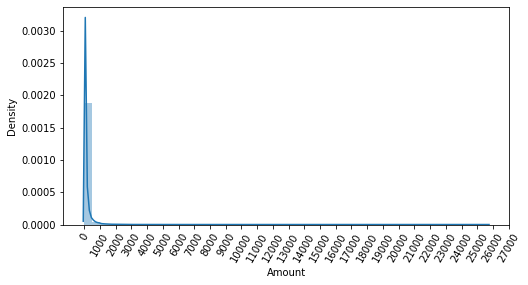

In [ ]:
import seaborn as sns
plt.figure(figsize = (8, 4))
plt.xticks(range(0, 30000, 1000), rotation = 60)
sns.distplot(card_df['Amount'])

- 카드 사용 금액이 1000불 이하인 데이터가 대부분으로, 27000불까지 드물지만 많은 금액을 사용한 경우가 발생하여 꼬리가 긴 형태의 분포 곡선을 가지고 있따.
- Amount를 표준 정규 분포 형태로 변환한 뒤 로지스틱 회귀의 예측 성능을 측정해보자. 앞에서 만든 `get_processed_df()` 함수에 사이킷런의 `StandardScaler` 클래스를 이용해 Amount Feature를 정규 분포 현태로 변환하는 코드를 추가해준다.

In [ ]:
from sklearn.preprocessing import StandardScaler

# 사이킷런의 StandardScaler를 이용하여 정규분포 형태로 Amount Feature 값 변환
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    scaler = StandardScaler()
    amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1, 1))

    # 변환된 Amount를 Amount_Scaled로 피처명 변경후 DataFrame 맨 앞 Column으로 입력
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    
    # 기존 Time, Amount 피처 삭제
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    return df_copy

- `et_train_test_dataset()`를 호출해 학습/테스트 데이터셋을 다시 생성한 후, `get_model_train_eval()`을 이용해 로지스틱 회귀와 LightGBM 모델을 각각 학습/예측/평가 해보자.

In [ ]:
# Amount를 정규분포 형태로 변환 후 로지스틱 회귀 및 LightGBM 수행
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85281    14]
 [   58    90]]
정확도: 0.9992, 정밀도: 0.8654, 재현율: 0.6081, F1: 0.7143, AUC:0.9702
### LightGBM 예측 성능 ###
오차 행렬
[[85289     6]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9492, 재현율: 0.7568, F1: 0.8421, AUC:0.9773


- 정규 분포 형태로 Amount Feature 값을 변환한 후와 그 이전을 비교했을 때, 모델의 성능이 크게 개선되지는 않았다.
- 이번에는 `StadardSclaer`가 아니라 로그 변환을 해보자. 
- 로그 변환은 데이터 분포도가 심하게 왜곡되어 있을 때 적용하는 중요 기법 중 하나이다. 원래 값을 log 값으로 변환해 원래 큰 값이 상대적으로 작은 값으로 바뀌기 때문에 데이터 분포도의 왜곡을 상당 수준 개선한다.
- numpy의 `log1p()`함수를 이용해 변환할 수 있다.

In [ ]:
def get_preprocessed_df(df=None):
    df_copy = df.copy()

    # 넘파이의 log1p( )를 이용하여 Amount를 로그 변환 
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    
    return df_copy

In [ ]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85283    12]
 [   59    89]]
정확도: 0.9992, 정밀도: 0.8812, 재현율: 0.6014, F1: 0.7149, AUC:0.9727
### LightGBM 예측 성능 ###
오차 행렬
[[85290     5]
 [   35   113]]
정확도: 0.9995, 정밀도: 0.9576, 재현율: 0.7635, F1: 0.8496, AUC:0.9786


- 두 모델 모두 정밀도, 재현율, ROC AUc에서 약간씩 성능이 개선되었다.

### | **이상치 데이터 제거 후 모델 학습/예측/평가**
___
- 이상치 데이터(Outlier)는 전체 데이터의 패턴에서 벗어난 이상 값을 가진 데이터이다. Outlier는 머신러닝 모델의 성능에 영향을 주기 때문에, 이러한 Outlier를 찾아내는 방법을 알아보고, 이를 제거한 후 다시 모델을 학습, 평가해보자.
- **IQR(Inter Quantile Range) 방식** : 사분위(Quantile) 값의 편차를 이용하는 기법으로 흔히 박스 플롯(Box Plot)으로 시각화할 수 있다.
  + 사분위 : 전체 데이터를 값이 큰 순으로 정렬한 후 이를 1/4씩으로 구간을 분할하는 것
  + IQR : 25% 구간인 Q1과 75% 구간인 Q3의 범위
  + 보통 IQR에 1.5를 곱해 생성된 범위를 이용해 최대값과 최솟값을 결정한 후, 이를 벗어나는 데이터를 이상치로 간주한다.
- Feature가 많이 있을 때, 모든 Feature의 이상치를 검출하면 시간이 오래 걸리므로, Label 값과 상관성이 높은 Feature들의 이상치 데이터를 검출하는 것이 좋다. 이를 위해 DataFrame이 `corr()`로 각 Feature의 상관도를 구한 뒤, 시본의 `heatmap`으로 시각화해보자.

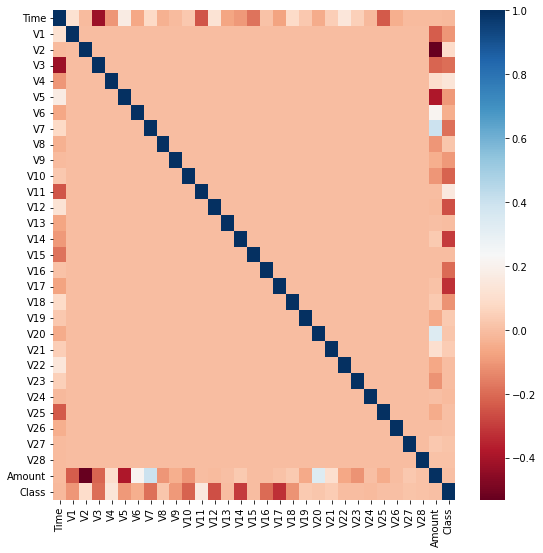

In [ ]:
import seaborn as sns

plt.figure(figsize=(9, 9))
corr = card_df.corr()
sns.heatmap(corr, cmap='RdBu')

- 시본의 `heatmap`은 `cmap`을 'RdBu`로 설정하면, 양의 상관관계가 높을수록 색깔이 진한 파란색이 되며, 음의 상관관계가 높을수록 진한 빨간색이 된다.
- 위 그래프에서 Class와 상관관계가 가장 높은 Feature은 V14와 V17이므로, 이들 중 V14의 이상치를 찾아 제거해보자.
- `get_outlier()` 함수 : 인자로 DataFrame과 이상치를 검출할 Column을 받는다. 그리고 넘파이의 `percentile()`을 이용해 Q1과 Q3 값을 구하고 이를 이용하여 IQR을 계산한다. 계산된 IQR에 1.5를 곱해 최댓값과 최솟값 지점을 구한 뒤, 이를 이상치를 판단하는 범위로 설정한다. 반환값은 해당 이상치가 있는 DataFrame의 Index이다.

In [ ]:
import numpy as np

def get_outlier(df=None, column=None, weight=1.5):
    # fraud에 해당하는 column 데이터만 추출, 1/4 분위와 3/4 분위 지점을 np.percentile로 구함
    fraud = df[df['Class']==1][column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)

    # IQR을 구하고, IQR에 1.5를 곱하여 최대값과 최소값 지점 구함
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    
    # 최대값 보다 크거나, 최소값 보다 작은 값을 아웃라이어로 설정하고 DataFrame index 반환
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
    return outlier_index    

In [ ]:
outlier_index = get_outlier(df=card_df, column='V14', weight=1.5)
print('이상치 데이터 인덱스:', outlier_index)

이상치 데이터 인덱스: Int64Index([8296, 8615, 9035, 9252], dtype='int64')


- 이 반환된 인덱스를 이용해 `get_processed_df()`함수에서 이상치를 삭제하는 코드를 추가해보자.

In [ ]:
# get_processed_df( )를 로그 변환 후 V14 피처의 이상치 데이터를 삭제하는 로직으로 변경. 
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    # 이상치 데이터 삭제하는 로직 추가
    outlier_index = get_outlier(df=df_copy, column='V14', weight=1.5)
    df_copy.drop(outlier_index, axis=0, inplace=True)
    return df_copy

In [ ]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)
print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85281    14]
 [   48    98]]
정확도: 0.9993, 정밀도: 0.8750, 재현율: 0.6712, F1: 0.7597, AUC:0.9743
### LightGBM 예측 성능 ###
오차 행렬
[[85291     4]
 [   25   121]]
정확도: 0.9997, 정밀도: 0.9680, 재현율: 0.8288, F1: 0.8930, AUC:0.9831


- 이상치를 제거한 후, 로지스틱 회귀와 LightGBM 모두 예측 성능이 크게 향상되었따.

### | **SMOTE 오버 샘플링 적용 후 모델 학습/예측/평가**
___
- SMOTE 기법으로 오버 샘플링을 적용한 뒤, 로지스틱 회귀와 LightGBM 모델을 학습시키고, 예측 성능을 평가해보자.
- SMOTE를 적용할 때는 반드시 학습 데이터셋만 오버 샘플링 해야 한다.
- 검증 데이터셋이나 테스트 데이터셋을 오버 샘플링하면 올바른 검증/테스트가 아니다.

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (199362, 29) (199362,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (398040, 29) (398040,)
SMOTE 적용 후 레이블 값 분포: 
 0    199020
1    199020
Name: Class, dtype: int64


- 학습 데이터셋이 199,632건에서 398,040건으로 증식되었다.
- 레이블 값이 균일한 분포를 이루게 되었다.

In [ ]:
# 로지스틱 회귀
lr_clf = LogisticRegression()

# ftr_train과 tgt_train 인자값이 SMOTE 증식된 X_train_over와 y_train_over로 변경됨에 유의
get_model_train_eval(lr_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)

오차 행렬
[[82937  2358]
 [   11   135]]
정확도: 0.9723, 정밀도: 0.0542, 재현율: 0.9247, F1: 0.1023, AUC:0.9737


- 로지스틱 회귀 모델의 경우, SMOTE로 오버 샘플링한 후 재현율이 92.47%로 크게 증가했지만, 정밀도가 5.4% 급격하게 저하되었다. 
- 분류 결정 임계값에 따른 정밀도와 재현율 곡선을 그려 SMOTE로 학습된 로지스틱 회귀 모델에 어떤 문제가 발생했는지 확인해보자.

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import precision_recall_curve
%matplotlib inline

def precision_recall_curve_plot(y_test , pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출. 
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()

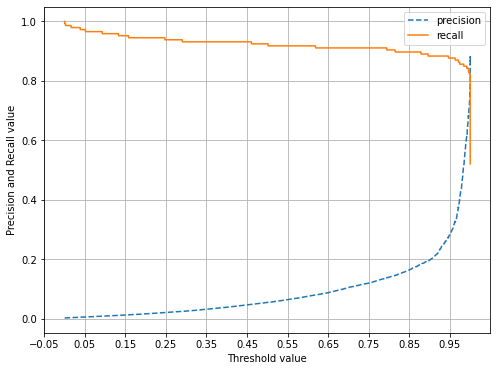

In [ ]:
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:, 1])

- 분류 결정 임계값을 조정하더라도 임계값의 민감도가 너무 심해 올바른 재현율/정밀도를 얻을 수 없다.
- 로지스틱 회귀 모델의 경우, SMOTE를 적용한 후 올바른 예측 모델이 생성되지 못했다.
- 이번에는 LightGBM 모델을 SMOTE로 오버 샘플링한 후, 학습/예측/평가를 수행해보자.

In [ ]:
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)

오차 행렬
[[85286     9]
 [   22   124]]
정확도: 0.9996, 정밀도: 0.9323, 재현율: 0.8493, F1: 0.8889, AUC:0.9789


- 재현율이 이상치만 제거한 경우보다 높은 84.93%가 되었지만 정밀도는 이전보다 낮은 93.23%이다. 